In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#print options to data exploration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


To begin forming our linear regression models we load in our imputed data set.

In [63]:
personal_path = '/content/drive/My Drive/'
path_full = os.path.join(personal_path, "biweekly_imputed_old.csv")
df = pd.read_csv(path_full)

For our first model the reponse will be the number of new Covid cases per million people on a particular day in a particular country. For now we not interested in predicting the reponse of future data points, rather we are interested in direct interpretation of the regression coefficients. Therefore, we forgo splitting the data into a train and test set. 

We also drop irrelevant/unineteresting features. For example, having the positive rate of Covid tests on a particular day will indeed be useful for predicting the number of new cases, but this relationship is fundamentally obvious. We want to uncover less intutive relationships.

We hope most of the predictor names are sufficiently descriptive. One point of clarification is for the variant predictors such as Alpha, Mu, Delta, etc. correspond to proportion of cases in a specific country on a specific date attributed to each variant. Thus, the sum of the variant data should be 1 for every country on every date.

In [64]:
y = df['new_cases_smoothed_per_million']
X = df.drop(['Unnamed: 0', 'new_cases_smoothed_per_million', 'date', 'total_cases_per_million','total_deaths_per_million','new_deaths_smoothed_per_million','total_tests_per_thousand','positive_rate','tests_per_case','hospital_beds_per_thousand','icu_patients_per_million','hosp_patients_per_million','iso_code','month_yr','population','reproduction_rate','new_tests_smoothed_per_thousand'], axis = 1)

Next, we examine the correlation between features in our data set. Recall that in a an Ordinary Least Squares Linear Regression we assume $Y_i = \beta_0 + \beta_1x_1 + \beta_1x_1 +\ldots + \beta_kx_k + ϵ_i$ where we have $k$ features and $\epsilon ~ \sim \mathcal{N}(0, \sigma^2)$. Under these assumptions the associated likelihhod is $\prod_i^n p(\vec{x_i})\cdot \frac{1}{(2\sigma^2\pi)^{\frac{1}{2}}} \cdot exp\{-\frac{(y_i-(\beta_0 + \sum_{j=1}^k\beta_jx_{ij}))^2}{2\sigma^2}\}$ and it can be shown that maximing this expression as a function of $\vec{\beta}$ is equivalent to minimizing $\sum_{i=1}^n(y_i-(\beta_0 + \sum_{j=1}^k\beta_jx_{ij}))^2$ in terms of $\vec{\beta}$. From here it follows that the regression coefficients can solved in closed form as $\hat{\vec{\beta}} = (X^TX)^{-1}X^TY$ where $X$ is our design matrix (matrix of predictors + a column of 1s for an intercept term) and $Y$ is our vector of responses. Note that $\hat{\vec{\beta}}$ depends on $(X^TX)^{-1}$ and that the latter expression will not be invertible if the columns of features are linearly dependent. Thus, if the columns of the design matrix are linearly dependent the OLS estimates for the coefficients cannot be solved for. Furthermore, by noting that $\hat{\vec{\beta}} \sim \mathcal{N}(0, (X^TX)^{-1}\sigma^2)$ we see that large values in $(X^TX)^{-1}$ will cause our coefficient estimates to be highly variable. Thus, we must also be careful to ensure that our design matrix is not near singluar as such a design matrix would yeild abnormally large values in $(X^TX)^{-1}$ and cause our estimates to be highly variable. To avoid this situation we analyze a correlation matrix of our features. Having features that are highly correlated will result in $(X^TX)^{-1}$ being near singular and so if a pair of features is highly correlated we will remove one of them. The plot below visualizes our correlation matrix. We are concerned about off-diagonal cells which are light green/yellow.

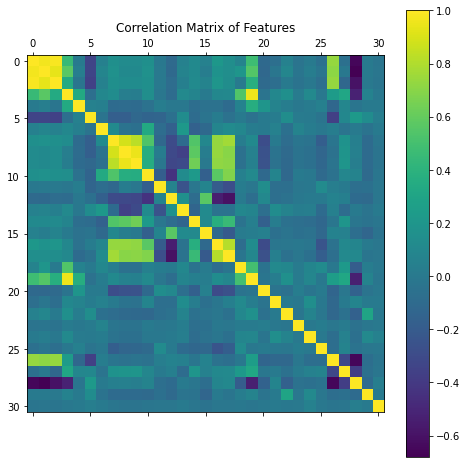

In [65]:
plt.figure(figsize=(8, 8))
plt.matshow(X.corr(), fignum = 1)
plt.colorbar()
plt.title('Correlation Matrix of Features')
plt.show()

We now drop the highly correlated predictors from our design matrix. We use a threshold of 0.8 to identify highly correlated pairs.

In [66]:
X.drop(['non_who','people_vaccinated_per_hundred','people_fully_vaccinated_per_hundred','daily_vaccinations_per_million','new_people_vaccinated_smoothed_per_hundred','life_expectancy','aged_70_older','human_development_index'], axis = 1, inplace = True)

We now fit our initial linear regression model. We display some verbose output from the regression below and analyze it in the proceeding cell.

In [67]:
import statsmodels.api as sm

#add a column of ones for the intercept term
X_full = sm.add_constant(X)
est_full = sm.OLS(y, X_full)
est_full_fit = est_full.fit()
print(est_full_fit.summary())

                                  OLS Regression Results                                  
Dep. Variable:     new_cases_smoothed_per_million   R-squared:                       0.156
Model:                                        OLS   Adj. R-squared:                  0.147
Method:                             Least Squares   F-statistic:                     17.58
Date:                            Fri, 10 Dec 2021   Prob (F-statistic):           7.25e-65
Time:                                    19:52:35   Log-Likelihood:                -14732.
No. Observations:                            2211   AIC:                         2.951e+04
Df Residuals:                                2187   BIC:                         2.965e+04
Df Model:                                      23                                         
Covariance Type:                        nonrobust                                         
                                            coef    std err          t      P>|t|      [0.

The first value to consider is the $R^2$ value. This is a measure of goodeness of fit and is defined as $R^2=1-\frac{\sum_{i=1}^n(y_i-\hat{y_i})^2}{\sum_{i=1}^n(y_i-\bar{y})^2}$. Evidently the closer $R^2$ is to 1 the better the model is at explaining the response. We will consider the adjusted $R^2$ value which penalizes for having many predictors. Such a penalty is logical since adding predictors to a linear regression model will only help its explanatory ability even if the added predictor is completly irrelavent. For our model $Adj. R^2 = 0.147$ which is rather low. Such a value can roughly be interpreted as meaning that the predictor variables account for 14.7% of the variability in the response variable. Nonetheless the model is not worthless. The $F-Test$ for overall model utility which has null hypothesis $H_0:$ our model and a model consisting of only an intercept term have the same explanatory capability, has a near zero p-value. Thus, we can conclude that the predictors do indeed have an effect on the response but they do not tell the entire story. We can also examine $t-tests$ for individual predictors. Each such test has the null hypothesis $H_0:$ the coefficient associated with the predictor is 0. Thus, if the p-value of such a test is large the predictor may not have any influence on the response and may be able to be removed without hindering the model. In our model, if we conduct the test at a 95% confidence level, the insignificant predictors are total vaccinations per hundred, new vaccinations smoothed per million, extreme poverty, diabetes prevalence, male smokers, daily people vaccinated per hundred, Beta, Kappa, Iota, Eta, Alpha, Lambda, and Mu. we now fit a model with these predictors removed and check to see if we can safetly justify their removal.

In [57]:
from statsmodels.stats.anova import anova_lm
X_nested = X.drop(['total_vaccinations_per_hundred','new_vaccinations_smoothed_per_million','extreme_poverty','diabetes_prevalence','male_smokers','daily_people_vaccinated_per_hundred','Beta','Kappa','Iota','Eta','Alpha','Lambda','Mu'], axis = 1)
X_nested_const = sm.add_constant(X_nested)
est_nested = sm.OLS(y, X_nested_const)
est_nested_fit = est_nested.fit()
print(anova_lm(est_nested_fit, est_full_fit))

   df_resid           ssr  df_diff       ss_diff         F    Pr(>F)
0    2192.0  7.679890e+07      0.0           NaN       NaN       NaN
1    2179.0  7.512923e+07     13.0  1.669668e+06  3.725075  0.000007


The above output details an $F-Test$ for nested linear regression models. The null hypothesis is $H_0:$ all coeffcients present in the full model but not the nested model are 0. In other words the hypothesis test is detirmining if the nested model accounts for the just as much variance in the reponse as the full model. In our case the p-value is 0.243 and so we fail to reject th null hypothesis and we can justifiably reduce the model. It is interesting to note that the number of vaccinations administered in a country does not seem to significantly influence the number of cases in the country. This may suggest that vaccinations are not particularly effective at preventing infections. We now exmaine the coefficients of this nested model.


In [58]:
print(est_nested_fit.summary())

                                  OLS Regression Results                                  
Dep. Variable:     new_cases_smoothed_per_million   R-squared:                       0.183
Model:                                        OLS   Adj. R-squared:                  0.176
Method:                             Least Squares   F-statistic:                     27.26
Date:                            Fri, 10 Dec 2021   Prob (F-statistic):           4.90e-83
Time:                                    19:45:23   Log-Likelihood:                -14696.
No. Observations:                            2211   AIC:                         2.943e+04
Df Residuals:                                2192   BIC:                         2.954e+04
Df Model:                                      18                                         
Covariance Type:                        nonrobust                                         
                                                 coef    std err          t      P>|t|    

Interpreting regression coefficients can be tricky. One needs to resist the temptation to fit a narraive to explain the why the coefficients take on certain values. For example, strigency_index is a metric developed by Our World in Data, that attempts to quantify how many restrictions a country has put in place to slow the spread of Covid-19. Countries with mask mandates, travel bans, and mandatory quarantines will have a higher strigency index than those countries which do not. The regression coefficient associated with strigency index is 3.0802, suggesting that the more restrictions a government puts in place the more Covid-19 spreads. Of course the true relationship is likely that the governments of countries in which there is a COVID-19 outbreak, and thus lots of new cases, are more likely to implement restrictive measures to slow the spread. Other interesting findings are that the only significant variants were Epsilon, Gamma, and Delta, all of which have positive coefficients. This could possibly suggest that these variants are more contagious. However, in the case of the Epsilon and Gamma variants the data is limited and so any conclusions should be take with a grain of salt. Another interesting note is that the female smoker predictor was significant but the male smoker predictor was not. We are hesistant to hypothesize why this is the case but perhaps the amount of female smokers in a country is a proxy for the nation's underlying ideology about government interventions. Lastly, it seems counter intuitive that median age is positively associated why aged 65 older is negatively associated.

We are also interested in directly comparing the magnitide of the effect of each predictor. To do this we standardize the predictors and re-fit the regression model. Note that with the scaled data no intercept term is necessary.

In [59]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler_y = StandardScaler()
y_scaled = scalery.fit_transform(np.array(y).reshape(-1,1))
cols = X_nested.columns
X_nested_scaled = pd.DataFrame(scaler.fit_transform(X_nested))
X_nested_scaled.columns = cols
est_nested_scaled = sm.OLS(y_scaled, X_nested_scaled)
est_nested_scaled_fit = est_nested_scaled.fit()
print(est_nested_scaled_fit.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.183
Model:                            OLS   Adj. R-squared (uncentered):              0.176
Method:                 Least Squares   F-statistic:                              27.27
Date:                Fri, 10 Dec 2021   Prob (F-statistic):                    4.45e-83
Time:                        19:45:25   Log-Likelihood:                         -2914.0
No. Observations:                2211   AIC:                                      5864.
Df Residuals:                    2193   BIC:                                      5967.
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------

From this output we can see that we see that the three predictors with greatest positive affect on the number of cases on a given day were strigency index, median age, and female smokers. Furthermore, we can now see that the Delta variant seems to be the most contagious.

The last analysis we will perform on this model will be the addition of categorical predictors. These added predictors correspond to the country and the month-year combination corresponding to each row.

In [60]:
X_nested['iso_code'], X_nested['month_year'] = df['iso_code'], df['month_yr']
X_nested_dummy = pd.get_dummies(X_nested, drop_first=True)
X_nested_dummy_const = sm.add_constant(X_nested_dummy)
est_dummy = sm.OLS(y, X_nested_dummy_const)
est_dummy_fit = est_dummy.fit()
print(est_dummy_fit.summary())

                                  OLS Regression Results                                  
Dep. Variable:     new_cases_smoothed_per_million   R-squared:                       0.486
Model:                                        OLS   Adj. R-squared:                  0.451
Method:                             Least Squares   F-statistic:                     13.96
Date:                            Fri, 10 Dec 2021   Prob (F-statistic):          2.07e-210
Time:                                    19:45:27   Log-Likelihood:                -14184.
No. Observations:                            2211   AIC:                         2.865e+04
Df Residuals:                                2070   BIC:                         2.945e+04
Df Model:                                     140                                         
Covariance Type:                        nonrobust                                         
                                                 coef    std err          t      P>|t|    

Including information about country and month/year drastically increases the model's explanatory ability. The model has $Adj. R^2 = 0.437$. Observing the p-values associated with the $t-tests$ for these new coeficients reveals two things. First, COVID-19 has affected some countries much more than others. It is evident that there differences between countreies which affect the number of COVID-19 cases which are not present in the data set. Second, the Covid-19 pandemic has increased and decreased in severity with November, 2020 being perhaps the worst month of the pandemic from a worldwide perspective.

We now conduct an entirely anaologous procedure, the only difference being that the response variable will now be new deaths smoothed per million rather than cases.

In [68]:
y = df['new_deaths_smoothed_per_million']
#add a column of ones for the intercept term
X_full = sm.add_constant(X)
est_full = sm.OLS(y, X_full)
est_full_fit = est_full.fit()
print(est_full_fit.summary())

                                   OLS Regression Results                                  
Dep. Variable:     new_deaths_smoothed_per_million   R-squared:                       0.295
Model:                                         OLS   Adj. R-squared:                  0.287
Method:                              Least Squares   F-statistic:                     39.74
Date:                             Fri, 10 Dec 2021   Prob (F-statistic):          2.80e-147
Time:                                     19:53:05   Log-Likelihood:                -5610.3
No. Observations:                             2211   AIC:                         1.127e+04
Df Residuals:                                 2187   BIC:                         1.141e+04
Df Model:                                       23                                         
Covariance Type:                         nonrobust                                         
                                            coef    std err          t      P>|t

Compared to the initial regression on new cases the regression on new deaths provides a moderatly better fit. We have $ADJ. R^2 = 0.287$ and a near zero p-value corresponding to the $F-Test$ for overall model utility. Examining the $t-tests$ for individual coefficients we see that the following are insignificant at a $95\%$ confidence level: new vaccinations smothed per million, extreme poverty, Beta, Iota, Eta, and Mu. One interesting finind is that the total number of vaccinations adminitered by a country was not significant in predicting new cases but IS significant in predicting new deaths. This suggests that the vaccines may not be effective at preventing infection but are effective at limiting extreme cases. After some testing all the insiginificant predictors could be removed simulatenously, therefore the predictior "daily people vaccinated per hundred" remains in the reduced model.

In [70]:
from statsmodels.stats.anova import anova_lm
X_nested = X.drop(['new_vaccinations_smoothed_per_million','extreme_poverty','Beta','Kappa','Iota','Eta','Mu'], axis = 1)
X_nested_const = sm.add_constant(X_nested)
est_nested = sm.OLS(y, X_nested_const)
est_nested_fit = est_nested.fit()
print(anova_lm(est_nested_fit, est_full_fit))

   df_resid           ssr  df_diff     ss_diff        F    Pr(>F)
0    2194.0  20817.700643      0.0         NaN      NaN       NaN
1    2187.0  20707.427754      7.0  110.272889  1.66377  0.113447


The removal of predictors is again justified by the large p-value of 0.113 in the $F-Test$ for nested linear regression models shown above. We now examine the values of the estimated parameters in the reduced model.

In [71]:
print(est_nested_fit.summary())

                                   OLS Regression Results                                  
Dep. Variable:     new_deaths_smoothed_per_million   R-squared:                       0.291
Model:                                         OLS   Adj. R-squared:                  0.286
Method:                              Least Squares   F-statistic:                     56.28
Date:                             Fri, 10 Dec 2021   Prob (F-statistic):          9.89e-151
Time:                                     20:05:55   Log-Likelihood:                -5616.2
No. Observations:                             2211   AIC:                         1.127e+04
Df Residuals:                                 2194   BIC:                         1.136e+04
Df Model:                                       16                                         
Covariance Type:                         nonrobust                                         
                                          coef    std err          t      P>|t| 

We see many of the same phenomena which were present in the new cases model such as a positive coefficient associated with the stringency index. One interesting thing to note is that diabetes prevalence is negatively associated with new deaths despite diabetes commonly being referred to as a co-morbitity. We hypothesize that this may be the case because diabetes is more prevalent in wealthier countries with bettwe healthcare systems. This would also align with the fact that GDP per capita is also negatively associated with new deaths. Lastly, we note that Delta, Alpha, Lambda, Gamma, and Epsilon variants may be more deadly though there is limited data for the latter three.

Next we standardize the coefficients to allow for a direct comparison of their magnitude.

In [72]:
scaler = StandardScaler()
scaler_y = StandardScaler()
y_scaled = scalery.fit_transform(np.array(y).reshape(-1,1))
cols = X_nested.columns
X_nested_scaled = pd.DataFrame(scaler.fit_transform(X_nested))
X_nested_scaled.columns = cols
est_nested_scaled = sm.OLS(y_scaled, X_nested_scaled)
est_nested_scaled_fit = est_nested_scaled.fit()
print(est_nested_scaled_fit.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.291
Model:                            OLS   Adj. R-squared (uncentered):              0.286
Method:                 Least Squares   F-statistic:                              56.31
Date:                Fri, 10 Dec 2021   Prob (F-statistic):                   8.35e-151
Time:                        20:32:53   Log-Likelihood:                         -2757.1
No. Observations:                2211   AIC:                                      5546.
Df Residuals:                    2195   BIC:                                      5637.
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------

With the data now standardized we see that the features with the greatest affect on increasing predictions about new deaths are: strigency index and median age. The features with the greatest affect on decreasing predictions about new deaths are: proportion of population older than 65 and total vaccinations per hundred. The seemingly contradicty coefficients associated with median age and aged 65 or older are again perplexing. Finally, we note that the Lambda variant may be substantially more deadly than others, though the large positive coefficient could also be due to the variant being most prevalent in under-developed countries.

Finally, we redo the regression and include categorical variables signifying country and month/year.

In [73]:
X_nested['iso_code'], X_nested['month_year'] = df['iso_code'], df['month_yr']
X_nested_dummy = pd.get_dummies(X_nested, drop_first=True)
X_nested_dummy_const = sm.add_constant(X_nested_dummy)
est_dummy = sm.OLS(y, X_nested_dummy_const)
est_dummy_fit = est_dummy.fit()
print(est_dummy_fit.summary())

                                   OLS Regression Results                                  
Dep. Variable:     new_deaths_smoothed_per_million   R-squared:                       0.553
Model:                                         OLS   Adj. R-squared:                  0.523
Method:                              Least Squares   F-statistic:                     18.46
Date:                             Fri, 10 Dec 2021   Prob (F-statistic):          1.52e-270
Time:                                     20:44:44   Log-Likelihood:                -5105.4
No. Observations:                             2211   AIC:                         1.049e+04
Df Residuals:                                 2071   BIC:                         1.129e+04
Df Model:                                      139                                         
Covariance Type:                         nonrobust                                         
                                          coef    std err          t      P>|t| 

Again we see that the including information about countries and month/year greatly improves the model. We now have $Adj. R^2 = 0.523$, meanig that 52.3% of the variance in the response can be explained by the predictors. This again suggests that the pandemic has been worse in some countries than others. Furthermore, it seems as if there remain meaningful differences between countries which are unaccounted for by country-specific quantitative variables in the data set. Finally, we can observe the coefficients for the month/year combinations and note that December, 2020 seems to have been the most deadly month in the pandemic worldwide.